In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# 
# read all files in train
train_files = os.listdir('train')
train_files = [f for f in train_files if f.endswith('.jpg')]

labels=[]

for f in train_files:
    label = f.split('.')[0]
    labels.append(label)


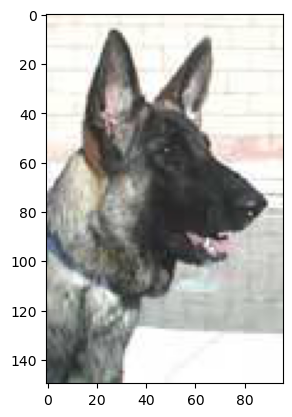

dog


In [2]:


image= Image.open('train/'+train_files[-1])

plt.imshow(image)
plt.show()

print(labels[-1])

In [6]:
def load_images(files):
    images = []
    for f in tqdm(files):
        image = Image.open('train/' + f)
        #reszie image to 224x224
        image = image.resize((224,224))
        x= np.array(image)
        x= x/255
        x=torch.tensor(x, dtype=torch.float32)
        x=x.permute(2,0,1)
        images.append(x)
    return images

all_images= load_images(train_files)

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
class_to_idx = {"dog":0, "cat":1}
idx_to_class = {0:"dog", 1:"cat"}

class Dataset:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.size = len(labels)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        x=self.images[idx]
        y= class_to_idx[self.labels[idx]]
        y= torch.tensor(y, dtype=torch.long)
        return x, y

train_dataset = Dataset(all_images, labels)
x, y = train_dataset[0]

print(x.shape)

torch.Size([3, 224, 224])


In [9]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.adjust_channels_conv_1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm_2d=torch.nn.BatchNorm2d(out_channels)
        self.relu=torch.nn.ReLU()
        
    def forward(self, input):
        x=input[0]
        identity=input[1]
        x=self.conv1(x)
        x=self.batch_norm_2d(x)
        x=self.relu(x)
        identity=self.adjust_channels_conv_1(identity)
        x=torch.add(x, identity)
        return x, identity
    
class ConvBlockMaxPool(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.adjust_channels_conv_1=torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm_2d=torch.nn.BatchNorm2d(out_channels)
        self.relu=torch.nn.ReLU()
        self.maxpool=torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
    def forward(self, input):
        x=input[0]
        identity=input[1]
        x=self.conv1(x)
        x=self.batch_norm_2d(x)
        x=self.relu(x)
        identity=self.adjust_channels_conv_1(identity)
        x=torch.add(x, identity)
        x=self.maxpool(x)
        identity=self.maxpool(identity)
        return x, identity
    
class DebugLayer(torch.nn.Module):
    def __init__(self, text):
        super().__init__()
        self.text=text
        
    def forward(self, input):
        x=input[0]
        identity=input[1]
        print(self.text, "x.shape:", x.shape)
        return x, identity


class CatsAndDogsModel(torch.nn.Module):
    def __init__(self, hidden_size=None, dropout=0.4):
        super().__init__()
        self.conv_layer=torch.nn.Sequential(
            ConvBlockMaxPool(3, 64,),       
            ConvBlockMaxPool(64, 128),          
            ConvBlockMaxPool(128, 256),         
            ConvBlockMaxPool(256, 512),         
            ConvBlockMaxPool(512, 1024),
            ConvBlockMaxPool(1024, 2048),
            #DebugLayer("nach conv_layer")
        )
     
        self.conv_size=2048*3*3
        self.lin1=torch.nn.Linear(self.conv_size, hidden_size)
        self.batch_norm_lin1=torch.nn.BatchNorm1d(hidden_size)
        self.lin2=torch.nn.Linear(hidden_size, 2)
        self.relu=torch.nn.ReLU()                           
        self.softmax=torch.nn.Softmax(dim=1)                
        self.dropout=torch.nn.Dropout(p=dropout)   
 
    def forward(self, x):
        #x=x.view(-1, 3, 32, 32)
        #print("x.shape nach x.view:", x.shape)
        original_x=x.clone()
        x, identity=self.conv_layer((x, original_x))
        
        #print("x.shape nach conv:", x.shape)
        # flatten
        x=x.view(-1, self.conv_size)
        #print("x.shape nach x.view:", x.shape)
        x=self.lin1(x)
        x=self.batch_norm_lin1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.lin2(x)
        #print("x.shape nach lin1:", x.shape)
        return x
    
# wir bauen das Modell
model=CatsAndDogsModel(hidden_size=100)
# wir bauen das Dataset
dataset_sample=Dataset(all_images, labels)
# wir bauen den DataLoader
loader=torch.utils.data.DataLoader(dataset_sample, batch_size=13, shuffle=True)
# ein einziges Batch-Beispiel wird aus dem Dataloader geladen
for xb, yb in loader:
    print(model(xb).shape)
    assert model(xb).shape==torch.Size([13, 2]), "Error: model(xb).shape!=torch.Size([13, 10])"
    break


torch.Size([13, 2])


In [10]:
from sklearn.model_selection import train_test_split

# wir bauen das Dataset
# stratify=mnist_trainset.targets sorgt dafür, dass die Klassenverteilung im Trainings- und Validierungsset gleich ist
x_train, x_valid, y_train, y_valid = train_test_split(all_images, labels, test_size=0.2, stratify=labels)
train_dataset=Dataset(x_train, y_train)
valid_dataset=Dataset(x_valid, y_valid)

In [11]:
def get_accuracy(model, dataset):
    loader=torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    model.eval()
    correct=0
    total=0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)   
            y_pred=model(xb)
            y_pred=torch.argmax(y_pred, dim=1)
            correct+=(y_pred==yb).sum().item()
            total+=len(yb)
    return correct/total

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

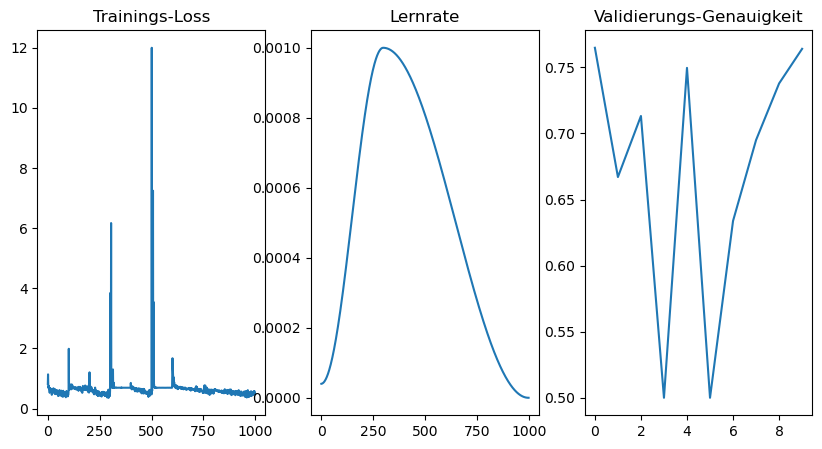

In [12]:
lr=0.001
batch_size=100
epochs=5
hidden_size=500
eval_steps=100

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

#device=torch.device('cpu')

model=CatsAndDogsModel(hidden_size).to(device)
#weight_decay: Hohe Gewichte werden bestraft, um Overfitting zu vermeiden
optimizer=torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)
#RMSprop: Optimierungsalgorithmus
#optimizer=torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=0.0001)
# OneCycleLR: Lernrate wird während des Trainings erhöht und dann wieder verringert
scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataset)//batch_size, epochs=epochs)

# CrossEntropyLoss: Klassifikationsproblem mit mehreren Klassen
loss_func=torch.nn.CrossEntropyLoss()

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

losses=[]
valid_losses=[]
learning_rates=[]
accs=[]

best_acc=0
postfix={}
for i in range(epochs):
    model.train()
    bar= tqdm(train_loader, total=len(train_loader), leave=False)  
    bar.set_description(f"Epoch {i+1}/{epochs}")
    steps=0
    bar.set_postfix(postfix)
    for xb, yb in bar:
        steps+=1
        bar.update(1)
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()                   # Gradienten (Ableitungen) zurücksetzen
        pred=model(xb)                          # Forward-Propagation
        loss=loss_func(pred, yb)                # Loss berechnen
        loss.backward()                         # ableiten
        optimizer.step()                        # Gewichte aktualisieren
        losses.append(loss.item())        # Loss speichern
        scheduler.step()                        # Lernrate aktualisieren
        learning_rates.append(scheduler.get_last_lr()[0])
        if steps%eval_steps==0:
            acc=get_accuracy(model, valid_dataset)
            accs.append(acc)
            if acc>best_acc:
                best_acc=acc
                torch.save(model.state_dict(), 'best_model.pth')
           
            postfix={
                    'loss': sum(losses[-eval_steps:])/eval_steps,
                    'lr': scheduler.get_last_lr()[0], 
                    'val_accuracy': acc
                 }
            bar.set_postfix(postfix)
            
    
fig, ax=plt.subplots(1,3, figsize=(10,5))
ax[0].plot(losses)
ax[0].set_title('Trainings-Loss')
ax[1].plot(learning_rates)
ax[1].set_title('Lernrate')
ax[2].plot(accs)
ax[2].set_title('Validierungs-Genauigkeit')

plt.show()

In [13]:
# save model

torch.save(model.state_dict(), 'model.pth')